In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from scipy.optimize import fsolve 
import sys
import time
from scipy import optimize
from numpy import savetxt

In [67]:
def Radius2fun(dimension,theta_r, c_r, m, Radius_t, c_initial):
    """
    This function generates a radius matrix.

    Args:
        dimension (int): The dimensions of the radius matrix.
        theta_r (array-like): An array of angle ranges from 0 to 2π/N with a length of "dimension".
        c_r (array-like): An array of the parameter "c" ranging from 0 to c_max with a length of "dimension".
        m (float): A scaling factor parameter "f(c)" as described in the referenced paper.

    Returns:
        numpy.ndarray: A radius matrix of size "dimension" x "dimension" for the specified parameter "m".
"""

    global N
    r0 = Radius_t # the radius of the inner tangent circle for the N-polygon pattern
    radius = np.zeros(shape = (dimension, dimension))
    for i in range(dimension):
        c = c_r[i]
        if i <=1:
            for j in range(dimension):
                theta = theta_r[j]
                R = r_solution_initial(r0, theta, c, m, Radius_t, c_initial)
                radius[i][j] = R
                r0 = R
        else:
            r0 = radius[i-1]
            R = r_solution_array(r0, theta_r, c, m, Radius_t, c_initial)
            radius[i] = R
    return radius

In [68]:
def r_solution_initial(r0, theta, c, m, Radius_t, c_initial):
    """
    This function uses "fsolve" to determine the precise radius "r"
    given an initial guess "r0", angle "theta", and parameters "c" and "m".

    Args:
        r0 (float): Initial guess for the radius.
        theta (float): The angle in the polar coordinate system.
        c (float): A parameter related to the scaling factor "f(c)" as described in the paper.
        m (float): Another parameter related to the scaling factor "f(c)" as described in the paper.
        
    Returns:
       (float): The exact radius corresponding to the given parameters, intended for use in the radius
       matrix radius[0][j].
    """

    data = (theta, c, m, Radius_t, c_initial)
    r,_,ier,mesg = fsolve(r2fun, r0, args=data, full_output=True)
    r_value = r.item(0)
    if ier != 1:
        print ("r_solution:I coudn't solve the algebraic constraint, error:\n\n:",r_value, theta,c, m)
    sys.stdout.flush()
    #r_value = sol.x
    return r_value

In [69]:
def r_solution_array(r0, theta, c, m, Radius_t, c_initial):
    """
    This function uses 'fsolve' to determine the precise radius 'r' given an initial guess 'r0', 
    an angle 'theta', and parameters 'c' and 'm'.

    Args:
        r0 (array): The initial guess for the radius, typically the previous value in the radius array.
        theta (float): The angle in the polar coordinate system.
        c (float): A scaling factor parameter, as described in the referenced paper.
        m (float): Another scaling factor parameter, as described in the referenced paper.
    Returns:
        array: The calculated radius array corresponding to the given parameters.
    """

    data = (theta, c, m, Radius_t, c_initial)
    r,_,ier,mesg = fsolve(r2fun, r0, args=data, full_output=True)
    if ier != 1:
        print ("r_solution:I coudn't solve the algebraic constraint, error:\n\n:",c, m)
    sys.stdout.flush()
    return r

In [70]:
def r2fun(r, *data):#polar coordinate
    """
    This function describes the shape of a droplet on an N-polygon substrate, 
    as specified by Equation S5. It will be submitted to "r_solution_initial" or "r_solution_array"
    to solve for the radius matrix given a droplet volume "v", and parameter "m".
    Args:
        R (float): The radius in the polar coordinate system.
        theta, c, m (tuple):
            theta (float): The angle in the polar coordinate system.
            c (float): A parameter for the scaling factor "f(c)" as defined in the paper.
            m (float): Another parameter for the scaling factor "f(c)" as defined in the paper.
    Returns:
        The left side of Equation S5, to be used for solving the radius matrix.
    """

    global THETA,N
    theta, c, m, Radius_t, c_initial= data
    f=1
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    ####Define the specific combinations of c and R 
    factor = (1 + (c-c_initial)/(1-c_initial))**m
    ####(make sure contours pass through the common point (0.5,0.5))
    for echo in range(N):
        i = echo+1
        fi = ((np.sin(i*THETA))*y + (np.cos(i*THETA))*x)/(factor*Radius_t)-1
        f = f*fi
    f = np.power(-1, N)*f
    return f-c

In [71]:
def average_mainfun(v, n, m, Radius_matix, Theta_ranges, C_ranges, Radius_t, c_initial):
    """
    Calculates the height and the surface area of a droplet given its volume 'v' and parameters 'm' and 'n'.

    Args:
        v (float): Droplet volume.
        m (float): Scaling factor parameter 'f(c)' as defined in the paper.
        n (float): Parameter defining the droplet height 'h = Hc^n' in the paper, where 'H' is the droplet height.
        Radius (ndarray): Matrix of radii corresponding to parameter 'm'.
        theta_ranges (ndarray): Array defining angle ranges from 0 to 2π/N with 'dimension' length.
        C_ranges (ndarray): Array defining parameter 'c' ranges from 0 to c_max with 'dimension' length.

    Returns:
        H (float): Droplet height under parameters 'n' and 'm'.
        surface_size (float): Droplet surface area under parameters 'n' and 'm'.
    """

     
    global N
    c_max = 0.999
    dimen_c = len(C_ranges)
    DELTA_THETA = Theta_ranges[2]-Theta_ranges[1]
    DELTA_C = C_ranges[2]-C_ranges[1]
    
    dev_h_c = dev_h_c2fun(C_ranges, n, c_initial)
    ds_base = (1/2)*(Radius_matix**2)*DELTA_THETA
    ds_2 = np.delete(ds_base, -1, axis=1)
    ds_3 = np.delete(ds_base, 0, axis=1)

    delta_base_2 = np.sum(ds_2, axis=1)
    delta_base_3 = np.sum(ds_3, axis=1)
    
    dela_base_average = 0.5*(delta_base_2+delta_base_3)
    
    #dela_base_average = np.sum(ds_base, axis=1)
    
    dv = (dela_base_average*dev_h_c)*DELTA_C
    dv2 = np.delete(dv, -1, axis=0)
    dv3 = np.delete(dv, 0, axis=0)
    dv_average = 0.5*(dv2+dv3)
    #dv_average = dv
    
    
    
    dv_sum = np.sum(dv_average)
    H = v/(dv_sum*N)##### Eq.S13 the droplet height is determinded under given "n" and "m"
    
    dev_r_theta = dev_r_theta2fun(Theta_ranges, Radius_matix, C_ranges, m, Radius_t, c_initial)
    dl = np.sqrt(Radius_matix**2 + dev_r_theta**2)*DELTA_THETA####Eq.S15

    d_h = H*dev_h_c
    dh = d_h.reshape(-1,1)
    d_r_c = dev_r_C2fun(Theta_ranges, Radius_matix, C_ranges, m, Radius_t, c_initial)
    
    #########################################################
    d_r_c[0][dimen_c//2] = 0 #when c=0, the d_r_c is not derivative, so to avoid the singularity
    #########################################################
    
    
    
    ds_surface = np.sqrt(dh**2+d_r_c**2)*DELTA_C####Eq.S16
    surface = dl*ds_surface####the integral part in Eq.S14 

    
    surface1 = np.delete(surface, -1, axis=0)
    surface2 = np.delete(surface1, -1, axis=1)
    
    surface3 = np.delete(surface, 0, axis=0)
    surface4 = np.delete(surface3, 0, axis=1)
    
    surface = 0.5*(surface2+surface4)
    
    surface_size = np.sum(surface)*N
    return H, surface_size, dela_base_average[0]*N

In [72]:
def dev_h_c2fun(c, n, c_initial):
    """
    This function computes the partial derivative of height (h) with respect to c,
    denoted as (\partial h)/(\partial c), which corresponds to the third part in Eq.S9 but without info of "H".

    Args:
        c (array): Array of parameter values ranging from 0 to c_max
        with 'dimension' number of elements.
        n (float): Parameter used in the droplet height definition h = H * c^n in the paper,
        where H is the droplet height.

    Returns:
    (array):Array of partial derivatives of height with respect to parameter c,
    scaled by a constant factor of H.
    """
    
  


    return (n*np.power(c-c_initial,n-1))/np.power(1-c_initial,n)

In [73]:
def dev_r_theta2fun(Theta_ranges, Radius_matrix, C_ranges, m, Radius_t, c_initial):
    """
    Calculates the partial derivatives of the radius with respect to the angle
    (\(\partial R / \partial \theta\)), as described in Equation S18.

    Args:
        theta_ranges (array-like): Array of angle ranges from 0 to \(2\pi/N\), 
        with a length specified by the "dimension".
    Radius (array-like): Matrix representing the radius for a given parameter "m".
    c_ranges (array-like): Array of parameter "c" ranges from 0 to \(c_{\text{max}}\),
    with a length specified by the "dimension".
    m (float): Scaling factor parameter "f(c)" as described in the paper.
    
    Returns:
        numpy.ndarray: Matrix of partial derivatives of the radius with respect to the angle.
    """
    factor = (1 + (C_ranges-c_initial)/(1-c_initial))**m
    C_N_factor = np.reshape(factor, (-1,1))
    
    #####The rescale f(c) factor to sure contours pass through the common point (0.5,0.5)
    Sin = np.sin(Theta_ranges)
    Cos = np.cos(Theta_ranges)
    R_sin = Radius_matrix*Sin
    R_cos = Radius_matrix*Cos
    eq1 = R_cos - Radius_t*C_N_factor
    eq2 = R_cos + Radius_t*C_N_factor
    eq3 = R_sin - Radius_t*C_N_factor
    eq4 = R_sin + Radius_t*C_N_factor
############################
    d_eq1_1 = Cos
    d_eq2_1 = Cos
    d_eq3_1 = Sin
    d_eq4_1 = Sin
###########################
    d_eq1_2 = -R_sin
    d_eq2_2 = -R_sin
    d_eq3_2 =  R_cos
    d_eq4_2 =  R_cos
###
    z_denominator = (d_eq1_1*eq2*eq3*eq4+d_eq2_1*eq1*eq3*eq4+d_eq3_1
                     *eq2*eq1*eq4+d_eq4_1*eq1*eq3*eq2 )
    z_numerator = -(d_eq1_2*eq2*eq3*eq4+d_eq2_2*eq1*eq3*eq4+d_eq3_2
                     *eq2*eq1*eq4+d_eq4_2*eq2*eq3*eq1)
    dev_r_theta = z_numerator/z_denominator
    return dev_r_theta

In [74]:
def dev_r_C2fun(Theta_ranges,  Radius_matrix, C_ranges, m, Radius_t, c_initial):
    """
    This function computes the partial derivatives of the radius (R)
    with respect to the parameter (c), as described in Equation S19.

    Args:
        theta_ranges (array): An array representing the angle ranges 
        from 0 to 2π/N with a specified length ("dimension").
        Radius (matrix): A matrix of radius values corresponding to a particular parameter "m".
        c_ranges (array): An array of parameter "c" values ranging from 0 to
        c_max with a specified length ("dimension").
        m (float): A scaling factor parameter "f(c)" as defined in the paper.

    Returns:
        matrix: A matrix containing the partial derivatives of the radius with respect to the parameter "c".
    """
    global N
    c = np.reshape(C_ranges, (-1,1))
    C_N_factor = (1 + (c-c_initial)/(1-c_initial))**m
    Sin = np.sin(Theta_ranges)
    Cos = np.cos(Theta_ranges)
    R_sin = Radius_matrix*Sin
    R_cos = Radius_matrix*Cos
    eq1 = R_cos - Radius_t*C_N_factor
    eq2 = R_cos + Radius_t*C_N_factor
    eq3 = R_sin - Radius_t*C_N_factor
    eq4 = R_sin + Radius_t*C_N_factor
    ############################
    d_eq1_1 = Cos
    d_eq2_1 = Cos
    d_eq3_1 = Sin
    d_eq4_1 = Sin
    ###########################
    z_denominator = (d_eq1_1*eq2*eq3*eq4+d_eq2_1*eq1*eq3*eq4+d_eq3_1
                     *eq2*eq1*eq4+d_eq4_1*eq1*eq3*eq2)
    c_n_factor = m*((1 + (c-c_initial)/(1-c_initial))**(m-1))*(1/(1-c_initial))
    
    C_derv_1 = -((Radius_t*C_N_factor)**N + c*N*(Radius_t**N)*(C_N_factor**(N-1))*c_n_factor)
    C_derv_2 =  Radius_t*c_n_factor*(-eq2*eq3*eq4 + eq1*eq3*eq4 - eq1*eq2*eq4 + eq1*eq2*eq3)
    z_numerator = C_derv_1 + C_derv_2
    dev_r_c = -z_numerator/z_denominator
    return dev_r_c

In [75]:
N = 4 # Initial number of sides for the square pattern
THETA = (2*np.pi)/N # The interior angle, denoted as \varphi in paper
###### coefficients in Eq.S6:


In [76]:
def Main_M(c_initial, Radius_t, dimen, m_ranges, n_ranges, v):
    dc = 1e-3
    C_ranges = np.linspace(c_initial+dc, 0.999, dimen)
    Theta_ranges = np.linspace(0, (2*np.pi)/N, dimen)
    m_length = len(m_ranges)
    n_length = len(n_ranges)
    M_n_surface_matrix = np.zeros((m_length, n_length))
    M_n_height_matrix = np.zeros((m_length, n_length))
    M_n_surface_bottom_matrix = np.zeros((m_length, n_length))
    for i in tqdm(range(m_length)):
        Radius_matrix = Radius2fun(dimen, Theta_ranges, C_ranges, m_ranges[i], Radius_t, c_initial)# raidus matrix for certain m
        for j in range(n_length):
            n_h, n_s, bottom_base = average_mainfun(v, n_ranges[j],m_ranges[i], Radius_matrix, Theta_ranges,
                                                    C_ranges, Radius_t, c_initial)
            M_n_surface_matrix[i][j] = n_s
            M_n_height_matrix[i][j] = n_h
            M_n_surface_bottom_matrix[i][j] = bottom_base
    surface_small = M_n_surface_matrix.min()
    index = np.where(M_n_surface_matrix == np.min(M_n_surface_matrix))
    height = M_n_height_matrix[index]
    bottom_surface = M_n_surface_bottom_matrix[index]
    return surface_small, height,bottom_surface, M_n_surface_matrix, m_ranges[index[0]], n_ranges[index[1]]

In [77]:
Volume = [0.5]
#C_min_ranges = np.array([ 0.8])
#R_t_ranges = np.array([1.55])
C_min_ranges = np.array([1e-3, 0.1, 0.3, 0.6, 0.8])#
R_t_ranges = np.array([0.5, 0.6, 0.73, 1.05, 1.55])#
m_ranges = np.arange(0.1, 3, 0.1)
n_ranges = np.arange(0.8, 1.6, 0.1)
ss_top = []
ss_base = []
hh = []
s_matrixs = []
m_indexs = []
n_indexs = []
Dimen = 200
for i in range(5):
    s_top, h, s_base, s_matrix, m,n= Main_M(C_min_ranges[i], R_t_ranges[i], Dimen, m_ranges, n_ranges, Volume[0])
    ss_top.append(s_top)
    hh.append(h)
    ss_base.append(s_base)
    s_matrixs.append(s_matrix)
    m_indexs.append(m)
    n_indexs.append(n)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [78]:
ss_top

[2.485835427973588,
 2.442622893235904,
 2.4311994004670003,
 2.4410917040012423,
 2.4504567810231657]

In [79]:
hh

[array([0.65601674]),
 array([0.61284771]),
 array([0.60080791]),
 array([0.55985063]),
 array([0.53947059])]

In [80]:
ss_base

[array([0.99699846]),
 array([1.21967055]),
 array([1.31963932]),
 array([1.46774462]),
 array([1.55017974])]

In [81]:
m_indexs

[array([1.]), array([0.7]), array([0.6]), array([0.5]), array([0.5])]

In [82]:
n_indexs

[array([1.2]), array([1.1]), array([1.2]), array([1.2]), array([1.3])]

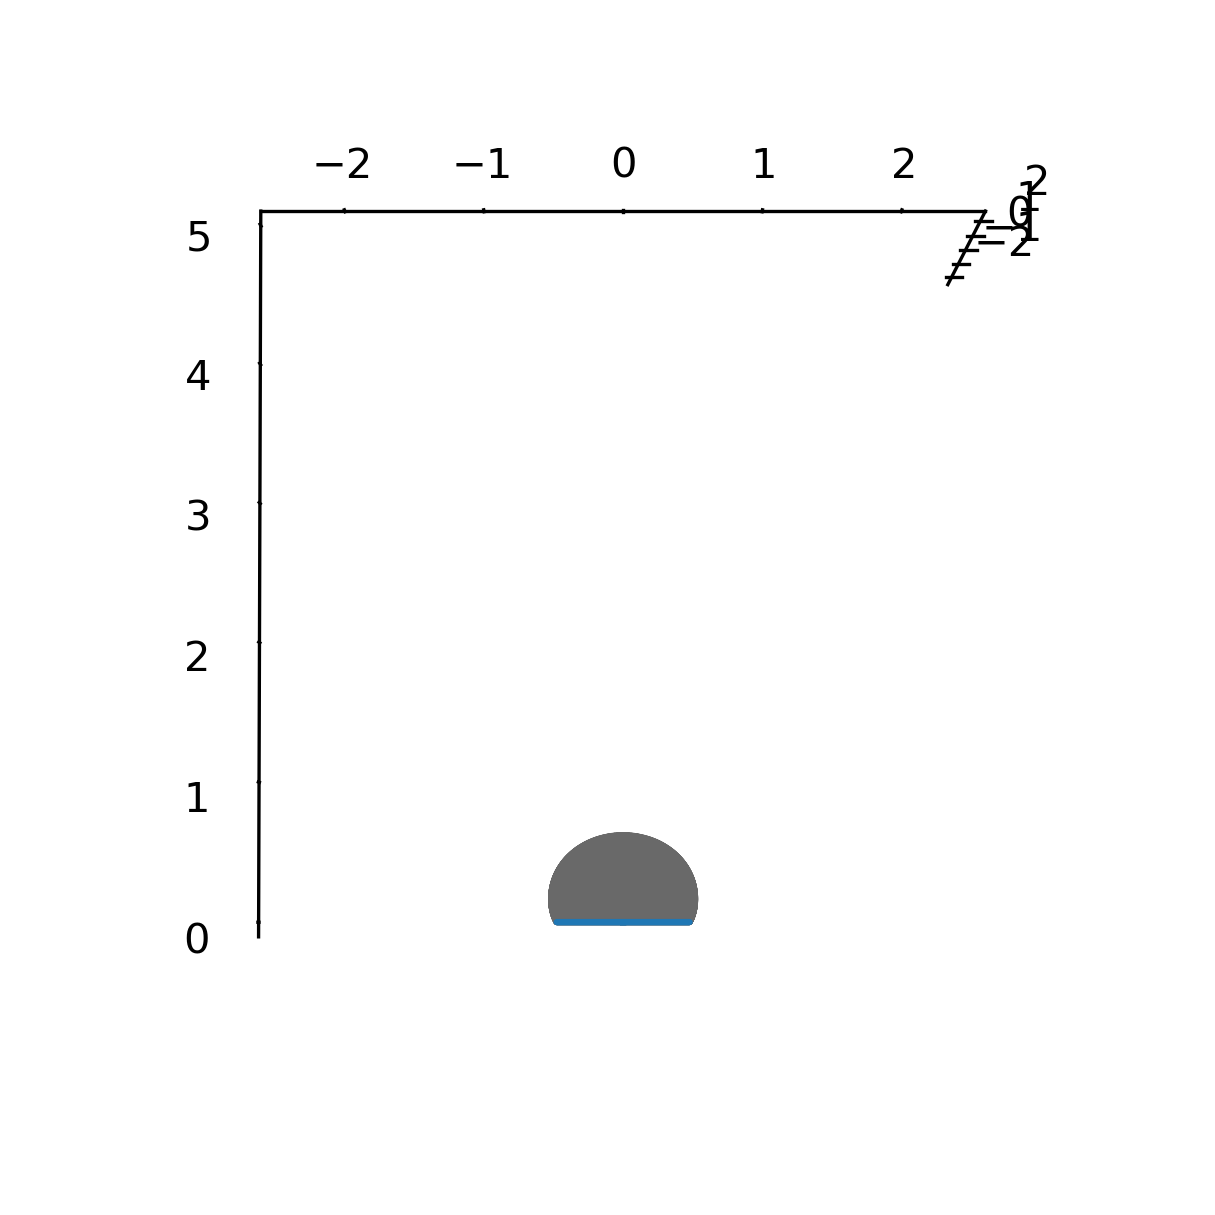

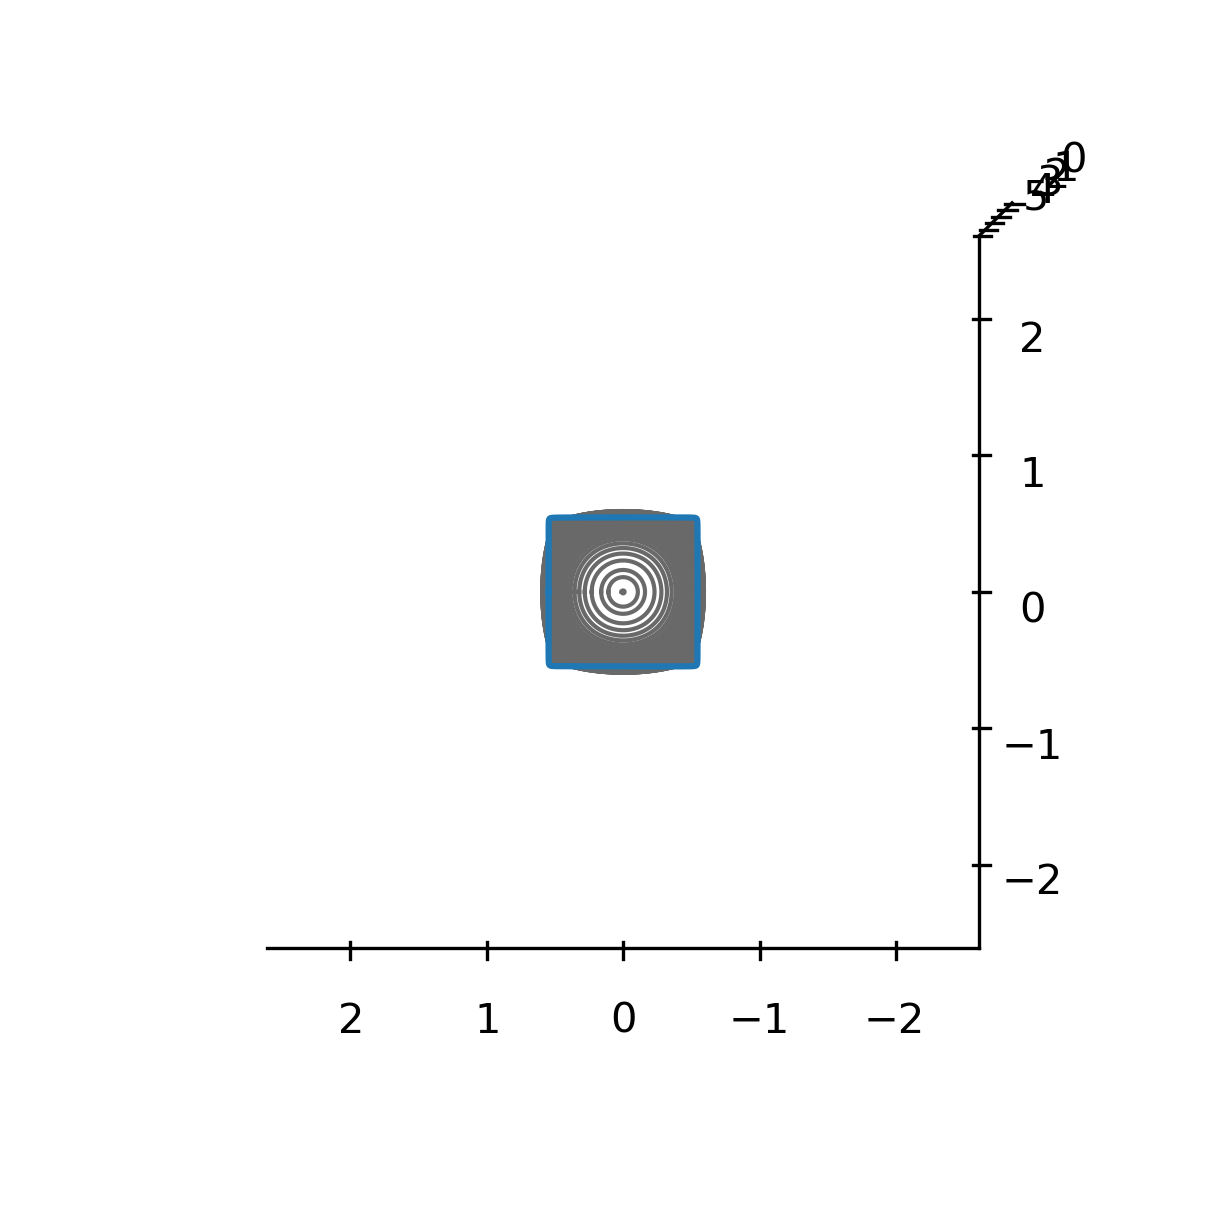

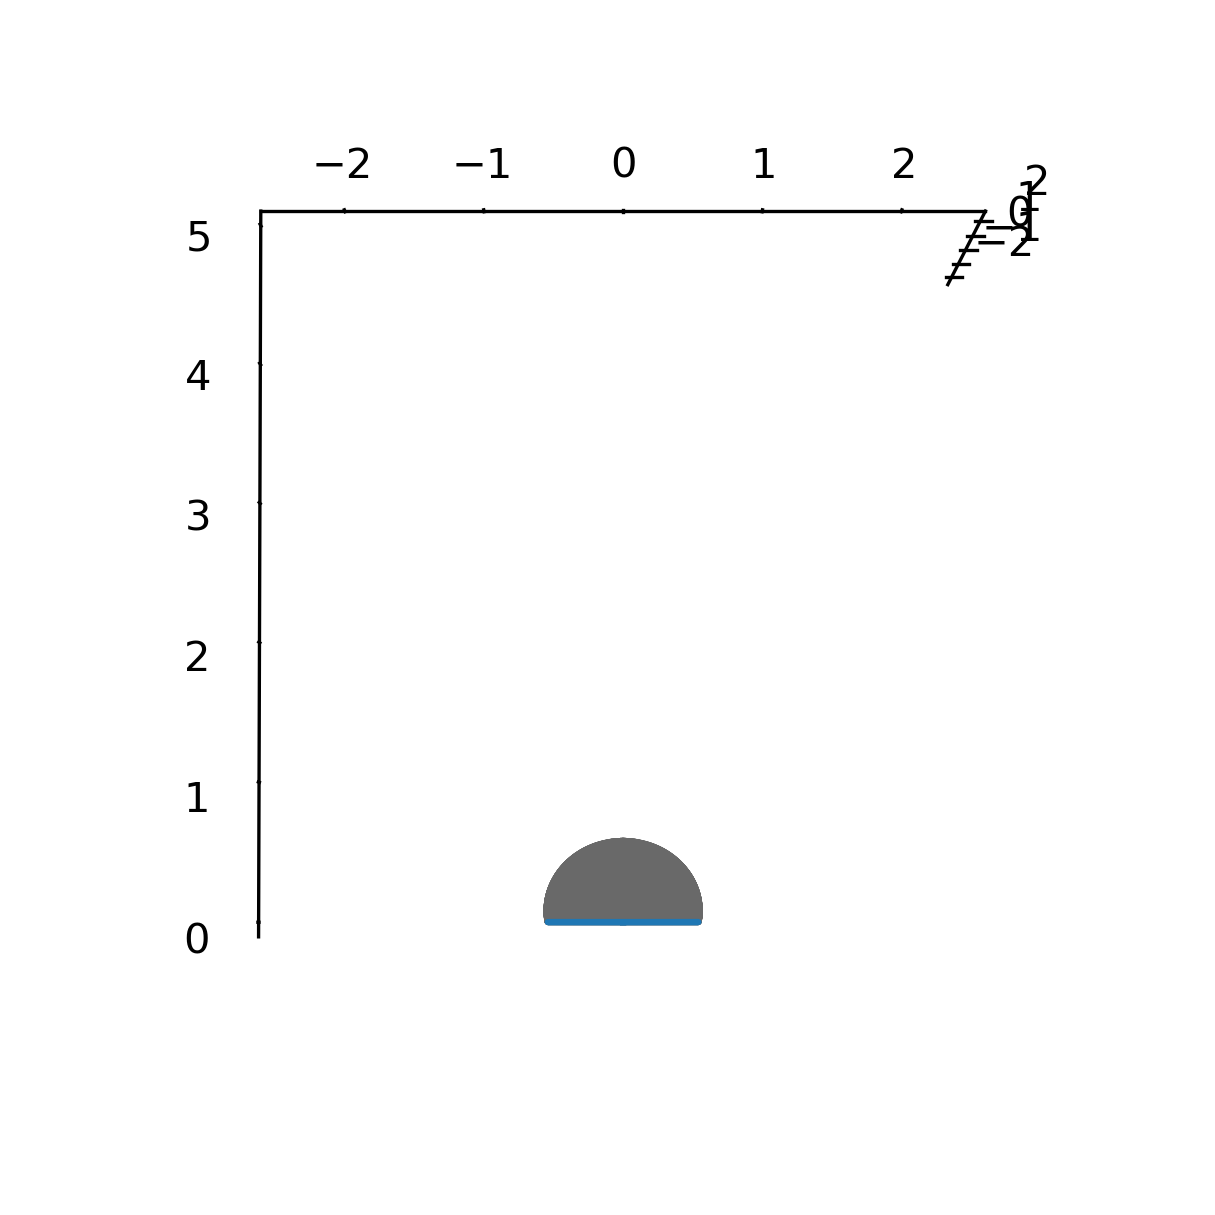

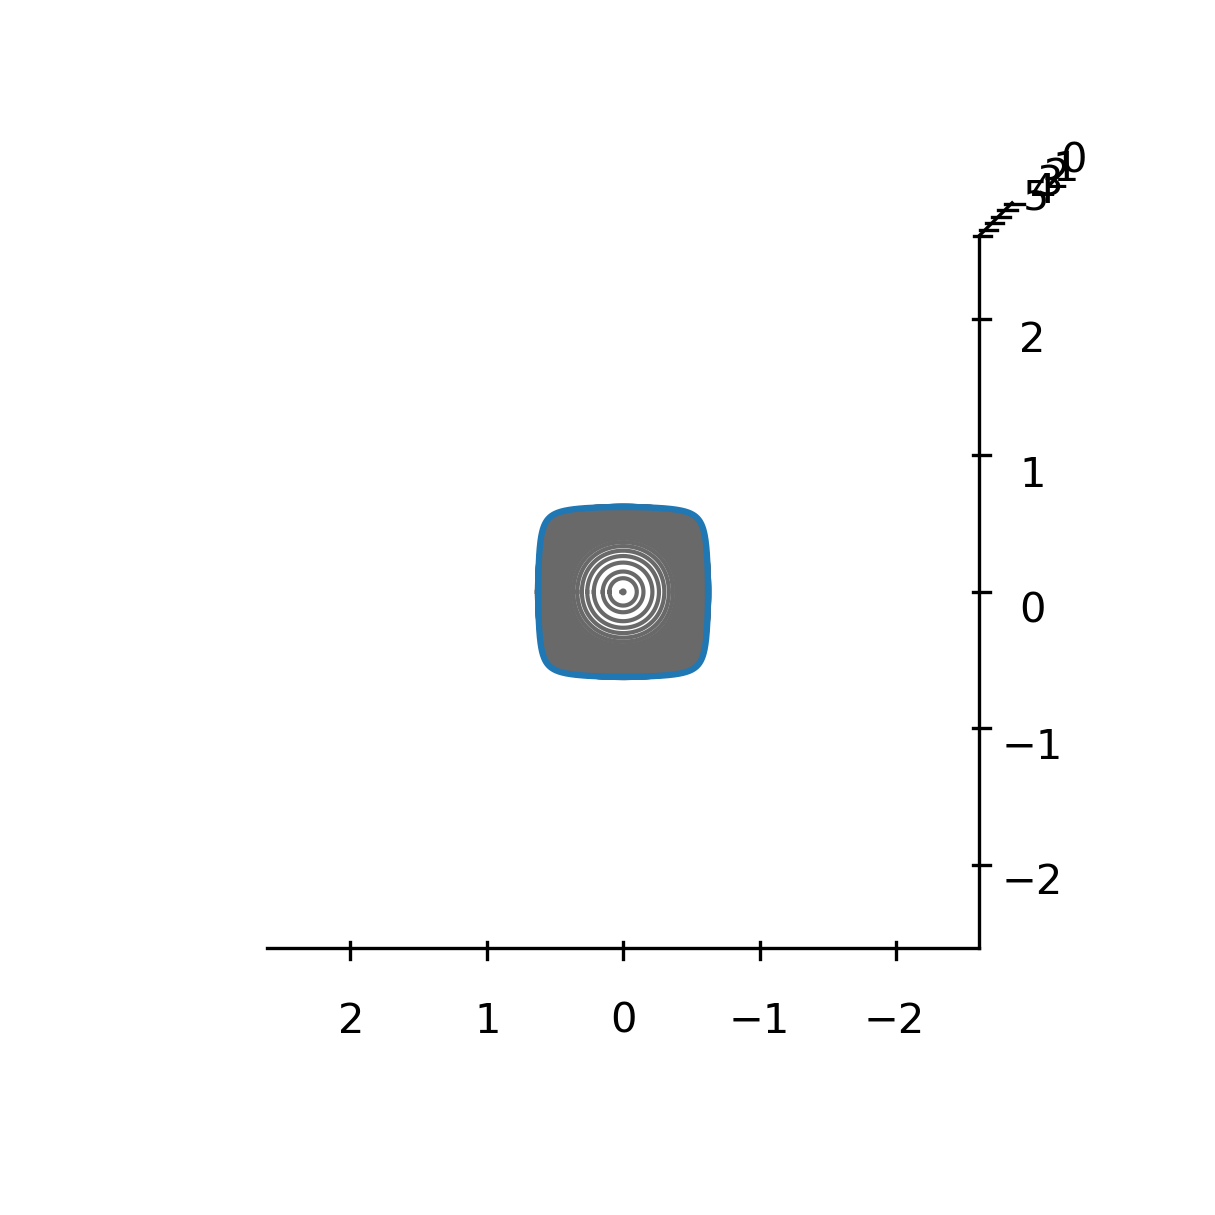

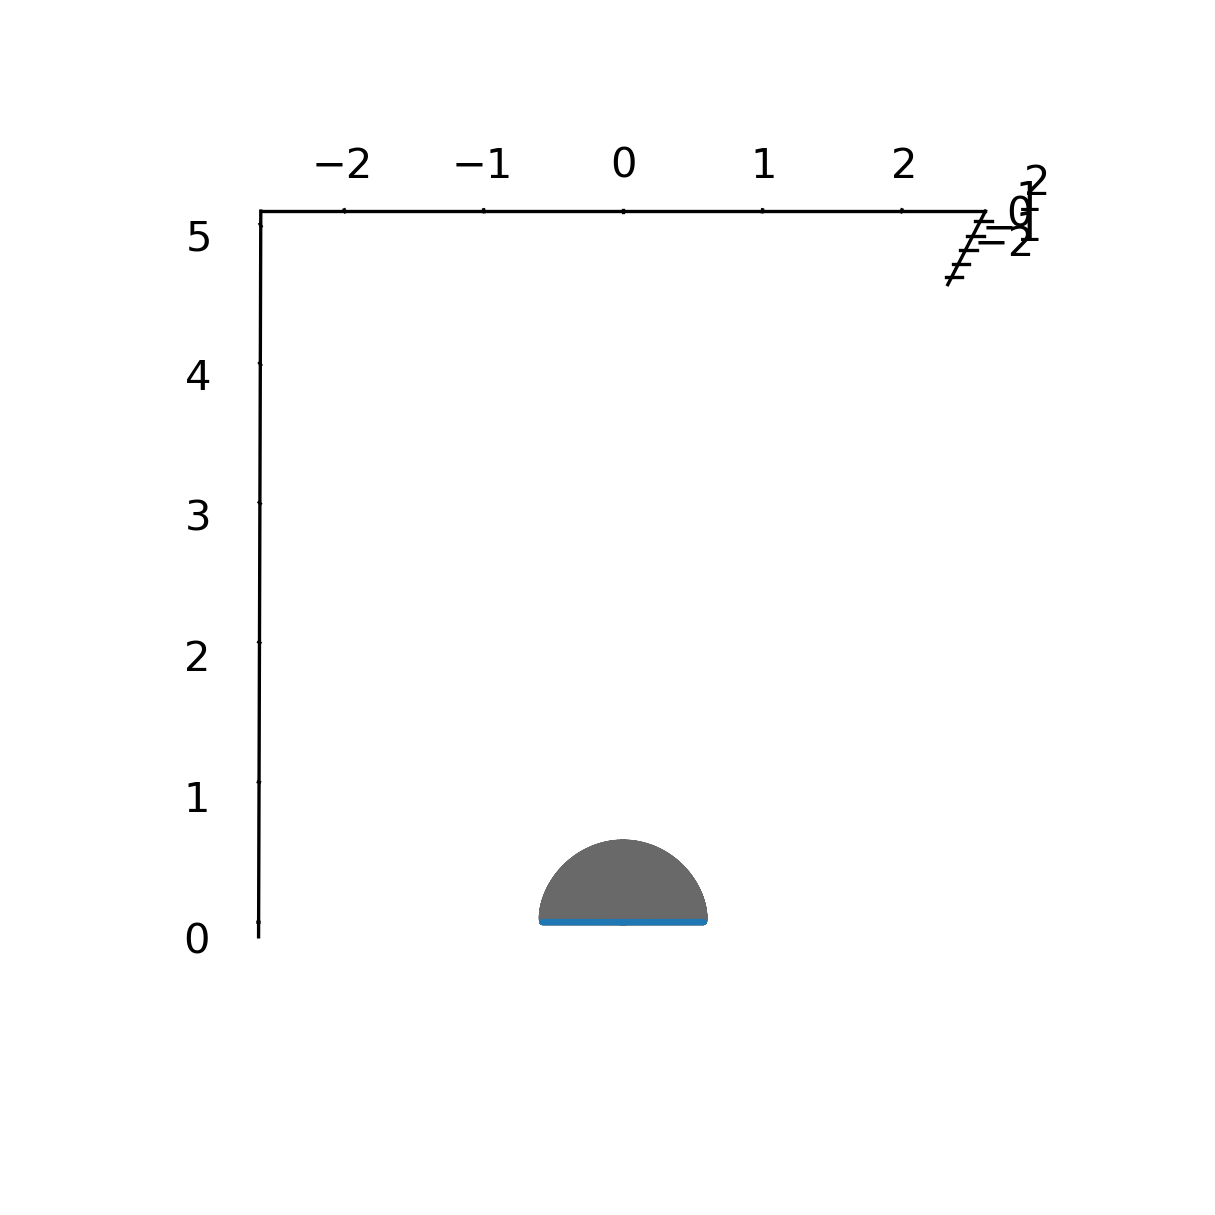

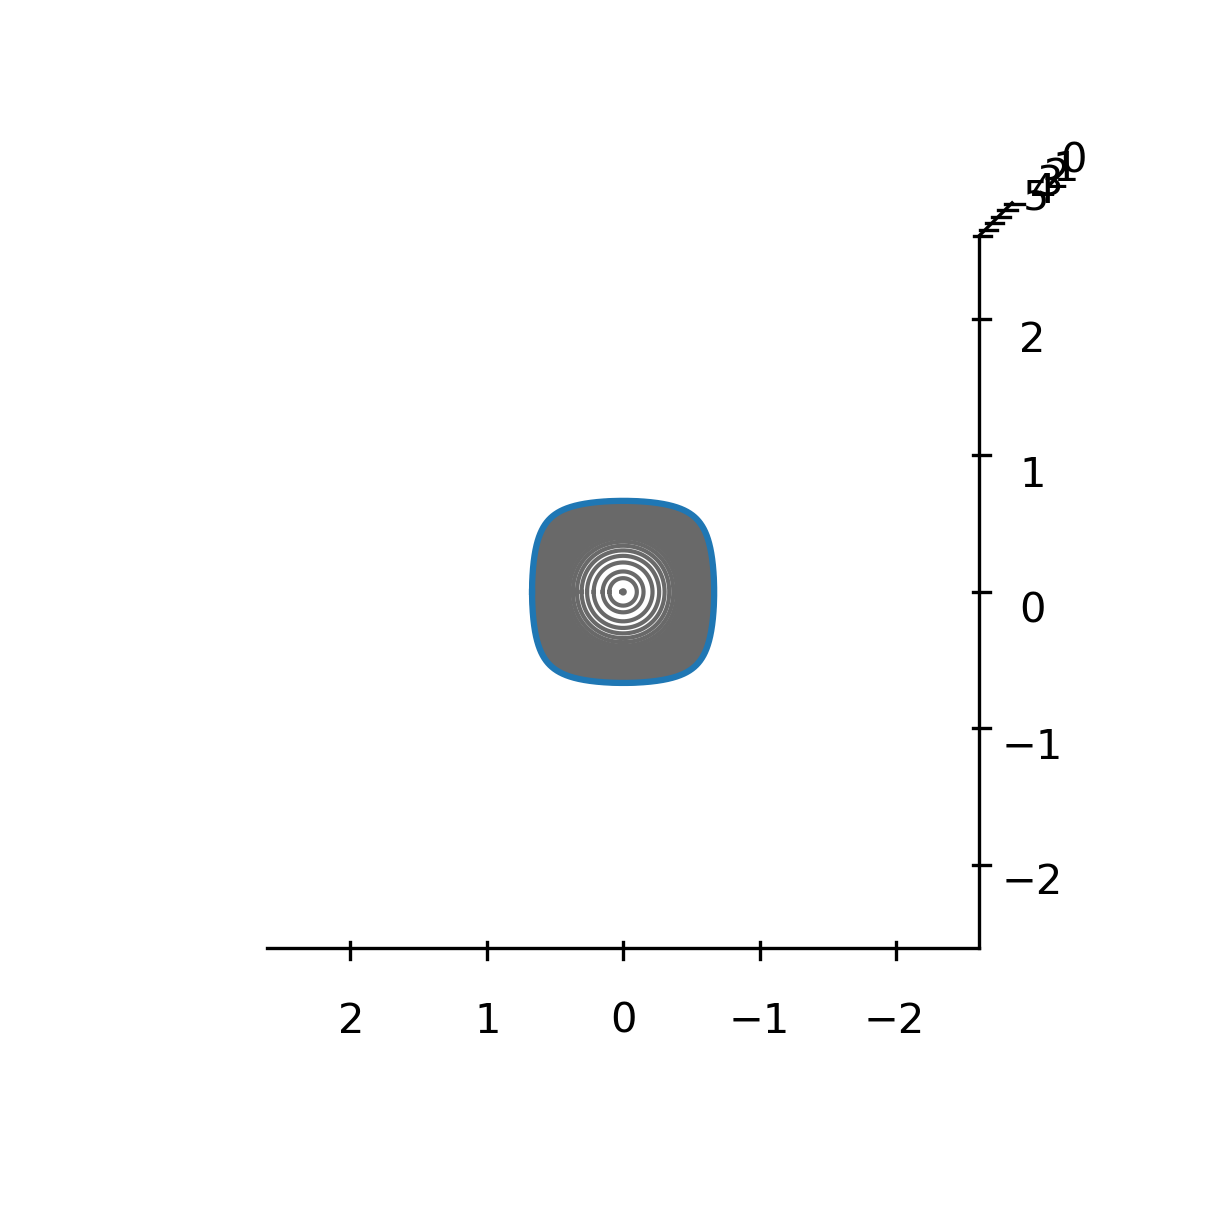

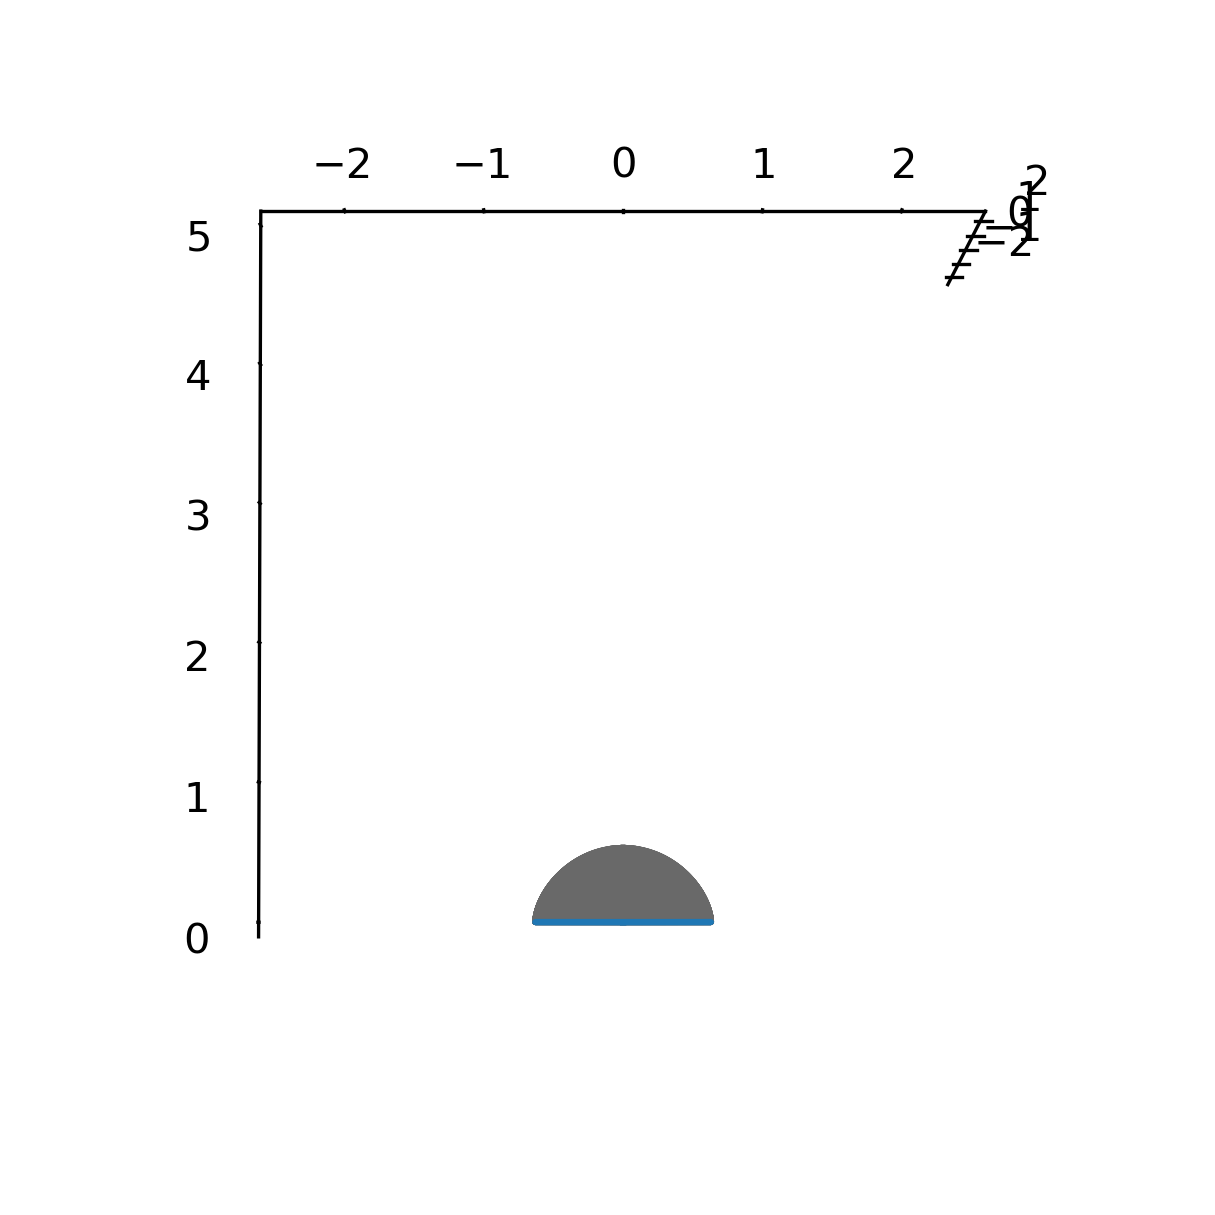

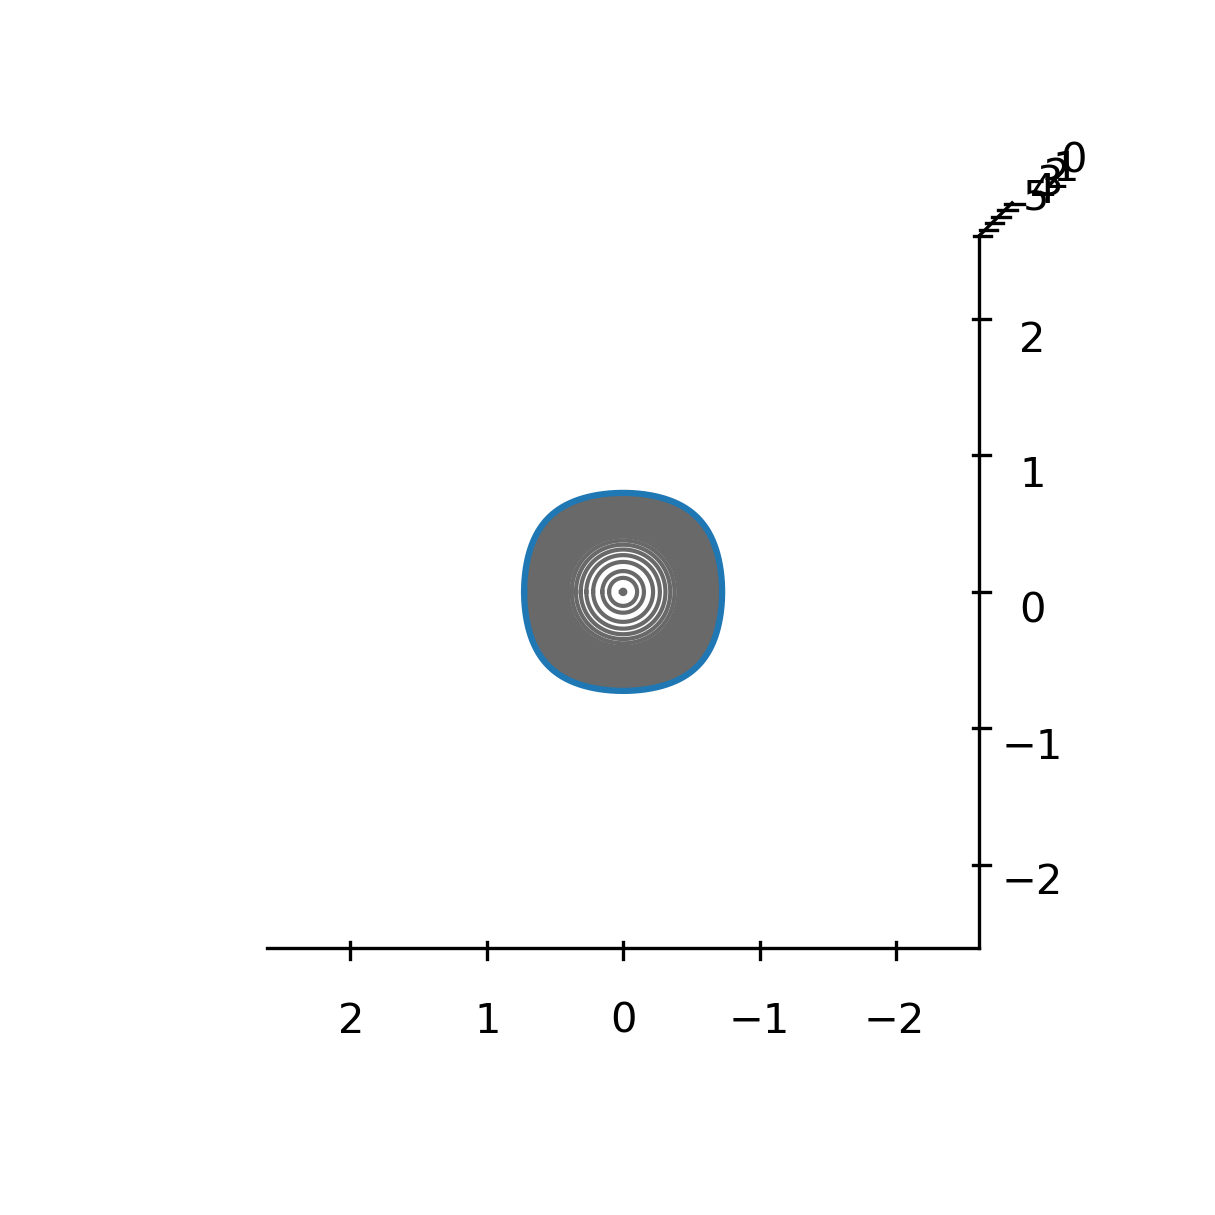

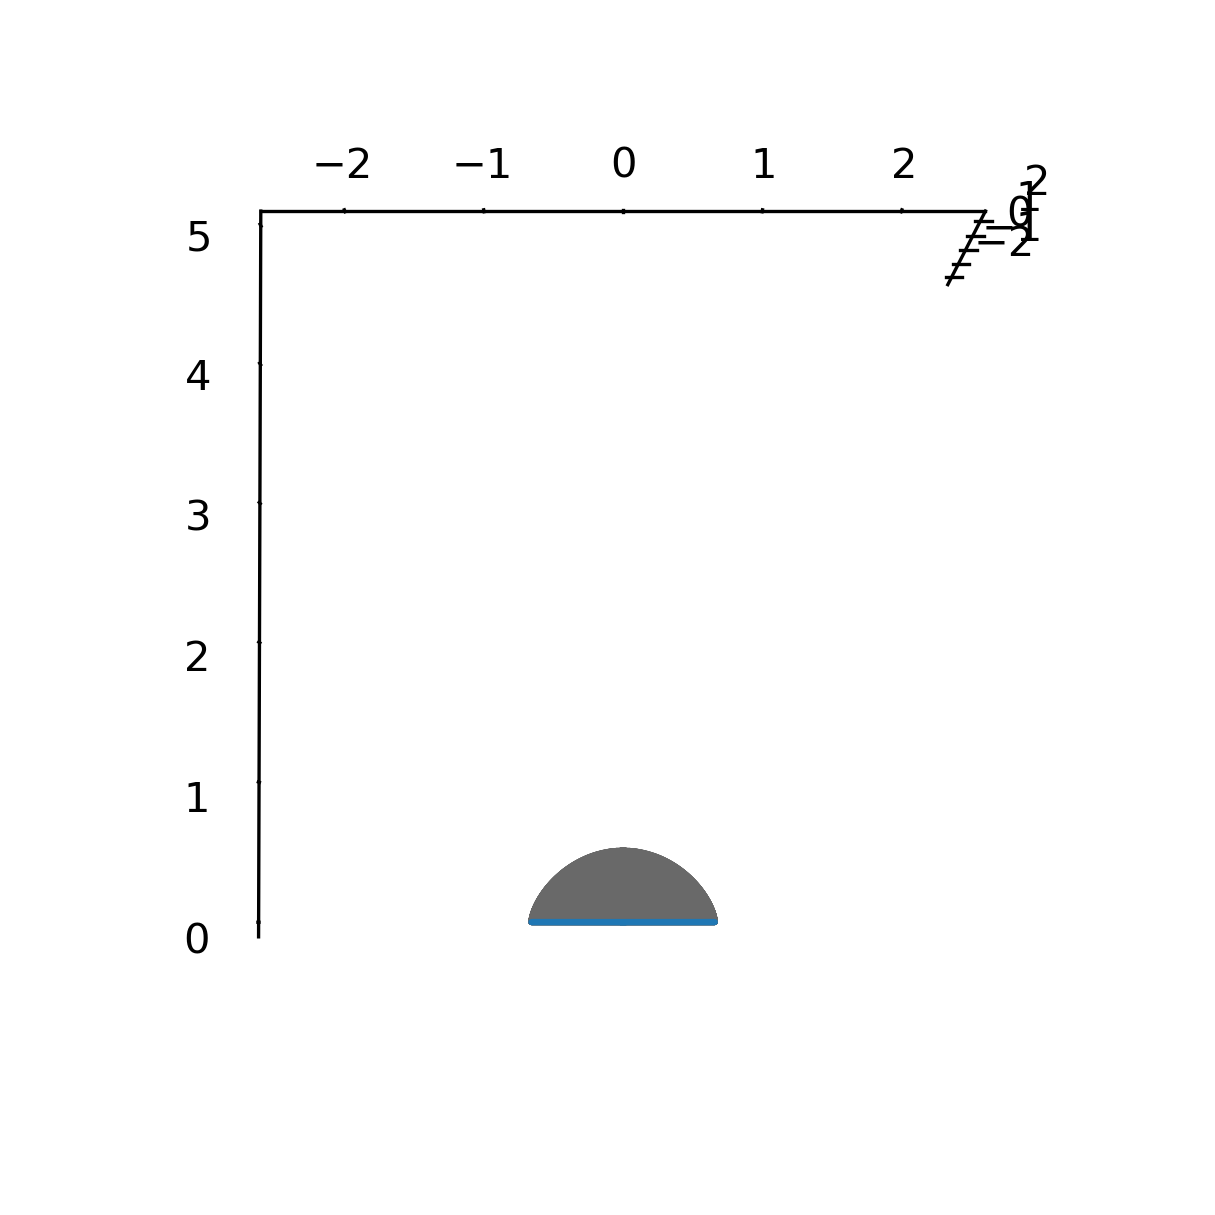

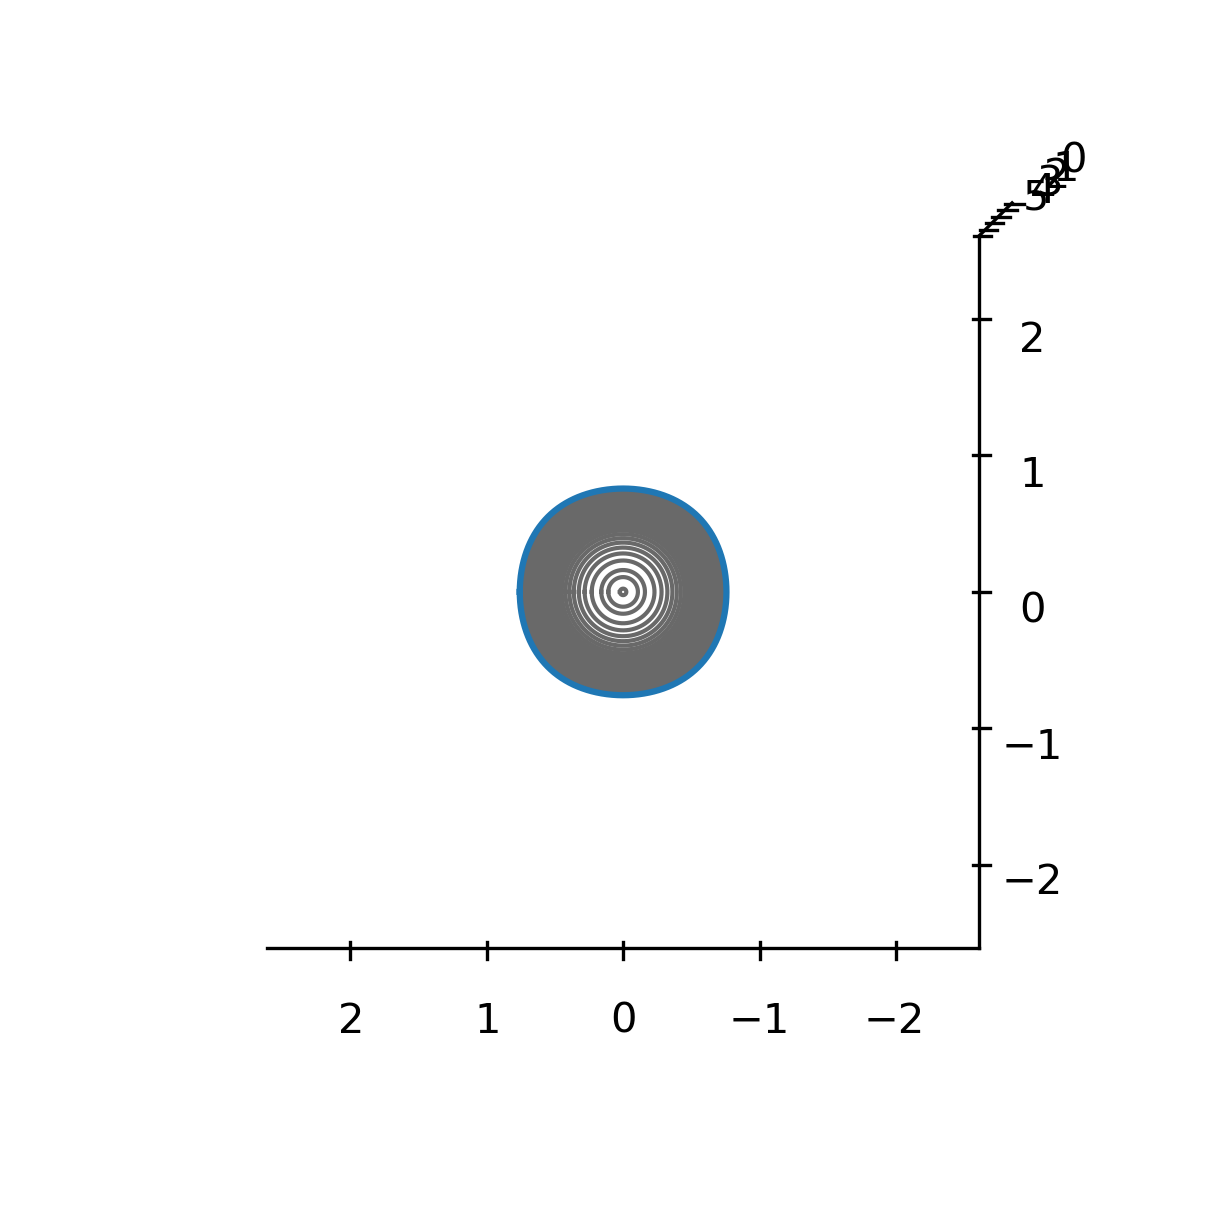

In [84]:
C_min_ranges = np.array([1e-3, 0.1, 0.3, 0.6, 0.8])
R_t_ranges = np.array([0.5, 0.6, 0.73, 1.05, 1.55])
for i in range(5):
    matrixNr = 400
    C_ranges = np.linspace(C_min_ranges[i], 0.9999, matrixNr)
    #C_ranges = np.linspace(0, 0.9999, matrixNr)
    theta_ranges = np.linspace(0, (2*np.pi)/N, matrixNr)
    m = m_indexs[i][0]
    R_200_0 = Radius2fun(400,theta_ranges, C_ranges, m, 0.5, 1e-16)
    R_200_0 = Radius2fun(matrixNr,theta_ranges, C_ranges, m, R_t_ranges[i], C_min_ranges[i])
    R_200_0_ = np.tile(R_200_0, 4)
    theta_ranges_2 = np.linspace(0, 2*np.pi, 4*matrixNr)
    x = R_200_0_*np.cos(theta_ranges_2)
    y = R_200_0_*np.sin(theta_ranges_2)
    #z = hh[i][0]*(C_ranges**(n_indexs[i][0]))
    z = hh[i][0]*(((C_ranges-C_min_ranges[i])/(1-C_min_ranges[i]))**(n_indexs[i][0]))
    z_0 = np.ones(400*4)
    ##############Plot top side views #######
    fig = plt.figure(figsize = (5,5), dpi=300)
    ax = plt.axes(projection='3d')
    ax.view_init(elev=-3, azim=0)
    plt.axis("equal")
    ax.set_box_aspect([1,1,1])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    for j in np.arange(0,matrixNr,1):
        ax.plot(x[j], y[j],z_0*z[j], color = 'dimgrey')
    ax.plot(x[0],y[0],z_0*z[0])
    #ax.plot(x[-10],y[-10],z_0*z[-10], color = 'dimgrey')
    ax.plot(x[-5],y[-5],z_0*z[-5], color = 'dimgrey')
    ax.plot(x[-1],y[-1],z_0*z[-1], color = 'dimgrey')
   # ax.set_axis_off()
    ax.set_zlim(0, 5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.grid(False)
    fig.savefig("contour_3D_side"+str(i)+".pdf", bbox_inches='tight')
    ###############Plot top views###########################
    fig_1 = plt.figure(figsize = (5,5), dpi=300)
    ax_1 = plt.axes(projection='3d')
    ax_1.view_init(elev=-90, azim=90)
    plt.axis("equal")
    ax.set_box_aspect([1,1,1])
    ax_1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax_1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax_1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    for j in np.arange(0,matrixNr,10):
        ax_1.plot(x[j], y[j],z_0*z[j], color = 'dimgrey', linewidth=1)
    ax_1.plot(x[0],y[0],z_0*z[0])
    #ax.plot(x[-10],y[-10],z_0*z[-10], color = 'dimgrey')
    ax_1.plot(x[-5],y[-5],z_0*z[-5], color = 'dimgrey', linewidth=1)
    ax_1.plot(x[-1],y[-1],z_0*z[-1], color = 'dimgrey', linewidth=1)
    #ax_1.set_axis_off()
    ax_1.set_zlim(0, 5)
    ax_1.set_xlim(-2.5, 2.5)
    ax_1.set_ylim(-2.5, 2.5)
    ax_1.grid(False)
    fig_1.savefig("contour_3D_top"+str(i)+".pdf", bbox_inches='tight')

In [85]:
def Contact_angles(R_base, Height):
    R_drop = (R_base**2 + Height**2)/(2*Height)
    cos_theta = (R_drop-Height)/R_drop
    theta = np.arccos(cos_theta)*180/np.pi
    return cos_theta, theta

In [86]:
cos_list = []
theta_list = []
for i in range(5):
    cos, theta = Contact_angles(R_t_ranges[i], hh[i][0])
    cos_list.append(cos)
    theta_list.append(theta)

In [87]:
cos_list


[-0.2650927466370729,
 -0.021183646597789037,
 0.19234321175579489,
 0.5572773704944595,
 0.7839053735038519]

In [88]:
theta_list

[105.37246388916027,
 91.21382433961014,
 78.91043695863365,
 56.13228189601761,
 38.380448264350456]